In [1]:
# 02-Model-Training-8.ipynb
# ======================================================================
# CELL 1: Imports and Environment Checks
# ======================================================================
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore', message='.*use_label_encoder*')

# For model training
from xgboost import XGBClassifier

# For data splitting, preprocessing, and searching
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# For dealing with imbalance
from imblearn.over_sampling import RandomOverSampler

# Quick check
xgb_temp_model = XGBClassifier()
print("XGBoost default params:", xgb_temp_model.get_xgb_params())
print("NumPy version:", np.__version__)

XGBoost default params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
NumPy version: 1.26.4


In [2]:
# ======================================================================
# CELL 2: Load the synthetic data (Users, Enriched)
# ======================================================================
CSV_FILE = r"/Users/harshil/Development/personal_projects/VeriShield-ML-Experiments/data_generators/synthetic_users_enriched.csv"

if not os.path.exists(CSV_FILE):
    raise FileNotFoundError(f"Cannot find '{CSV_FILE}'. Please run the data generator first.")

df_users = pd.read_csv(CSV_FILE)
print("Data loaded. Shape:", df_users.shape)
print("Columns:", df_users.columns.tolist())

Data loaded. Shape: (1500000, 16)
Columns: ['user_id', 'name', 'email', 'username', 'birthdate', 'gender', 'signup_ip', 'device_id', 'phone', 'country_code', 'created_at', 'burst_signup', 'fraud_label', 'email_domain', 'ip_count', 'num_fraud_biz_owned']


In [3]:
# ======================================================================
# CELL 3: Inspect and handle missing data
# ======================================================================
print("\n=== Missing values per column ===\n", df_users.isnull().sum())

initial_len = len(df_users)
# Must have fraud_label
if 'fraud_label' not in df_users.columns:
    raise ValueError("Missing 'fraud_label' in data; cannot proceed.")

df_users.dropna(subset=['fraud_label'], inplace=True)
after_drop_label_len = len(df_users)

# Fill missing string columns with "missing"
string_cols = ['name', 'email', 'username', 'phone', 'country_code', 'email_domain', 'device_id']
for col in string_cols:
    if col in df_users.columns:
        df_users[col] = df_users[col].fillna("missing")

print(f"\nDropped {initial_len - after_drop_label_len} rows due to missing fraud_label.")
print("Now shape:", df_users.shape)
print("\n=== Missing after fill ===\n", df_users.isnull().sum())


=== Missing values per column ===
 user_id                    0
name                   29837
email                  29912
username                   0
birthdate                  0
gender                     0
signup_ip                  0
device_id                  0
phone                  30093
country_code           37455
created_at                 0
burst_signup               0
fraud_label                0
email_domain               0
ip_count                   0
num_fraud_biz_owned        0
dtype: int64

Dropped 0 rows due to missing fraud_label.
Now shape: (1500000, 16)

=== Missing after fill ===
 user_id                0
name                   0
email                  0
username               0
birthdate              0
gender                 0
signup_ip              0
device_id              0
phone                  0
country_code           0
created_at             0
burst_signup           0
fraud_label            0
email_domain           0
ip_count               0
num_fraud_biz_

In [4]:
# ======================================================================
# CELL 4: Extra Feature Engineering
# ======================================================================
df = df_users.copy()

# 1) Convert 'gender' to binary (0=F, 1=M). If missing, fallback to 0.
if 'gender' in df.columns:
    df['gender'] = df['gender'].map({'F': 0, 'M': 1}).fillna(0)

# 2) Basic phone features
df['phone_len'] = df['phone'].apply(len)
df['phone_suspicious'] = df['phone'].apply(
    lambda x: 1 if any(s in x for s in ["+999", "666-666"]) else 0
)

# 3) Encode 'country_code'
if 'country_code' in df.columns:
    le_country = LabelEncoder()
    df['country_code_enc'] = le_country.fit_transform(df['country_code'].astype(str))
else:
    df['country_code_enc'] = 0  # fallback if missing

# 4) IP-based private check
if 'signup_ip' in df.columns:
    df['ip_private'] = df['signup_ip'].apply(
        lambda ip: 1 if ip.startswith("192.168") or ip.startswith("10.") else 0
    )
else:
    df['ip_private'] = 0

# 5) birth_year from birthdate
def extract_year(date_str):
    try:
        return int(date_str.split("-")[0])
    except:
        return 1970
df['birth_year'] = df['birthdate'].apply(extract_year)

# 6) day of year from created_at
df['signup_dayofyear'] = pd.to_datetime(df['created_at'], errors='coerce').dt.dayofyear.fillna(0)

# 7) email_domain as label-encoded
if 'email_domain' in df.columns:
    le_domain = LabelEncoder()
    df['email_domain_enc'] = le_domain.fit_transform(df['email_domain'].astype(str))
else:
    df['email_domain_enc'] = 0

# 8) ip_count -> numeric
df['ip_count'] = df['ip_count'].fillna(0).astype(int)

# 9) num_fraud_biz_owned -> numeric
df['num_fraud_biz_owned'] = df['num_fraud_biz_owned'].fillna(0).astype(int)

# 10) device collision count (similar to ip_count)
# Count how many users share the same device_id
if 'device_id' in df.columns:
    device_counts = df.groupby('device_id')['user_id'].transform('count')
    df['device_collision'] = device_counts.astype(int)
else:
    df['device_collision'] = 0

# 11) burst_signup as numeric
if 'burst_signup' in df.columns:
    df['burst_signup_flag'] = df['burst_signup'].astype(int)
else:
    df['burst_signup_flag'] = 0

# 12) synergy feature: phone_suspicious * burst_signup_flag
# (detect suspicious phone usage within a suspicious time burst)
df['synergy_burst_phone'] = df['phone_suspicious'] * df['burst_signup_flag']

# 13) synergy feature: ip_count + device_collision
# or a boolean if both exceed a threshold
df['multi_collision'] = ((df['ip_count'] > 2) & (df['device_collision'] > 1)).astype(int)

target_col = 'fraud_label'
y = df[target_col].values

# Extended feature set
feature_cols = [
    'gender',
    'phone_len',
    'phone_suspicious',
    'country_code_enc',
    'ip_private',
    'birth_year',
    'signup_dayofyear',
    'email_domain_enc',
    'ip_count',
    'num_fraud_biz_owned',
    'device_collision',
    'burst_signup_flag',
    'synergy_burst_phone',
    'multi_collision'
]
# Filter only columns that exist in df
feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].values
print("\nFeature columns used:\n", feature_cols)
print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)


Feature columns used:
 ['gender', 'phone_len', 'phone_suspicious', 'country_code_enc', 'ip_private', 'birth_year', 'signup_dayofyear', 'email_domain_enc', 'ip_count', 'num_fraud_biz_owned', 'device_collision', 'burst_signup_flag', 'synergy_burst_phone', 'multi_collision']
Feature matrix shape: (1500000, 14)
Target shape: (1500000,)


In [5]:
# ======================================================================
# CELL 5: Train/Test Split and Scaling
# ======================================================================
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

print("\nX_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Number of features:", X_test_scaled.shape[1])


X_train shape: (1200000, 14) y_train shape: (1200000,)
X_test shape: (300000, 14) y_test shape: (300000,)
Number of features: 14


In [6]:
# ======================================================================
# CELL 6: Imbalance Handling
# ======================================================================
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)

train_fraud_ratio = y_train.mean()
print("\nOriginal training set shape:", X_train_scaled.shape, 
      f"Fraud ratio: {train_fraud_ratio:.4f}")

res_fraud_ratio = y_train_res.mean()
print("Resampled training set shape:", X_train_res.shape, 
      f"Fraud ratio: {res_fraud_ratio:.4f}")

# Alternatively, you might skip oversampling and rely on XGBoost's scale_pos_weight
# scale_pos_weight = (1 - train_fraud_ratio) / train_fraud_ratio


Original training set shape: (1200000, 14) Fraud ratio: 0.3821
Resampled training set shape: (1482972, 14) Fraud ratio: 0.5000


In [7]:
# ======================================================================
# CELL 7.1: Hyperparameter Tuning (RandomizedSearchCV)
# ======================================================================
# We expand param_dist to handle more advanced hyperparams
param_dist = {
    'n_estimators': [100, 200, 500, 700],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 5],
    # 'scale_pos_weight': [1, 2, 3] # Optional if skipping oversampling
}

xgb_random = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# We'll use 'average_precision' which is typically more telling in fraud contexts
search = RandomizedSearchCV(
    estimator=xgb_random,
    param_distributions=param_dist,
    n_iter=15,  # increased from 10 to 15
    scoring='average_precision',
    cv=StratifiedKFold(n_splits=3),  # better stratification
    verbose=2,
    random_state=42
)

search.fit(X_train_res, y_train_res)

print("\n=== RandomizedSearchCV Results ===")
print("Best Params:", search.best_params_)
print("Best Score:", search.best_score_)

best_xgb_params = search.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:29:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=700, subsample=0.7; total time=   6.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:29:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=700, subsample=0.7; total time=   6.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:29:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=700, subsample=0.7; total time=   6.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   8.2s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   7.9s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   8.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   1.6s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   1.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   1.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   1.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   1.2s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   1.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   3.3s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   3.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   3.3s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=200, subsample=0.7; total time=   1.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=200, subsample=0.7; total time=   1.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=200, subsample=0.7; total time=   1.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   1.7s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   1.6s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   1.7s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   1.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   1.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   1.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   1.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   1.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:30:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   1.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   1.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   1.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   1.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   1.8s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   1.8s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   1.9s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   1.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   1.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   1.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   2.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   1.9s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   2.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7; total time=   1.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7; total time=   1.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, gamma=5, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7; total time=   1.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== RandomizedSearchCV Results ===
Best Params: {'subsample': 0.7, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best Score: 0.5836619817415616


In [8]:
# ======================================================================
# CELL 7.2: Define Final XGBoost Model
# ======================================================================
# Optionally, you could set scale_pos_weight if not oversampling
model = XGBClassifier(
    **best_xgb_params,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [9]:
# 02-Model-Training-7.ipynb

# ======================================================================
# CELL 1: Imports and Environment Checks
# ======================================================================
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore', message='.*use_label_encoder*')


# For model training
from xgboost import XGBClassifier

# For data splitting, preprocessing, and searching
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

# For dealing with imbalance
from imblearn.over_sampling import RandomOverSampler

# Quick checks
xgb_temp_model = XGBClassifier()
print("XGBoost default params:", xgb_temp_model.get_xgb_params())
print("NumPy version:", np.__version__)

XGBoost default params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
NumPy version: 1.26.4


In [10]:
# ======================================================================
# CELL 2: Load the synthetic data (Users, Enriched)
# ======================================================================
CSV_FILE = r"/Users/harshil/Development/personal_projects/VeriShield-ML-Experiments/data_generators/synthetic_users_enriched.csv"

if not os.path.exists(CSV_FILE):
    raise FileNotFoundError(f"Cannot find '{CSV_FILE}'. Please run the data generator first.")

df_users = pd.read_csv(CSV_FILE)
print("Data loaded. Shape:", df_users.shape)
print("Columns:", df_users.columns.tolist())

Data loaded. Shape: (1500000, 16)
Columns: ['user_id', 'name', 'email', 'username', 'birthdate', 'gender', 'signup_ip', 'device_id', 'phone', 'country_code', 'created_at', 'burst_signup', 'fraud_label', 'email_domain', 'ip_count', 'num_fraud_biz_owned']


In [11]:
# ======================================================================
# CELL 3: Inspect and handle missing data
# ======================================================================
print("Missing values per column:\n", df_users.isnull().sum())

initial_len = len(df_users)
df_users.dropna(subset=['fraud_label'], inplace=True)  # ensure we have a label
after_drop_label_len = len(df_users)

# Fill missing string columns with "missing"
string_cols = ['name', 'email', 'username', 'phone', 'country_code', 'email_domain']
for col in string_cols:
    if col in df_users.columns:
        df_users[col] = df_users[col].fillna("missing")

print(f"Dropped {initial_len - after_drop_label_len} rows due to missing fraud_label.")
print("Now shape:", df_users.shape)
print("Missing after fill:\n", df_users.isnull().sum())

Missing values per column:
 user_id                    0
name                   29837
email                  29912
username                   0
birthdate                  0
gender                     0
signup_ip                  0
device_id                  0
phone                  30093
country_code           37455
created_at                 0
burst_signup               0
fraud_label                0
email_domain               0
ip_count                   0
num_fraud_biz_owned        0
dtype: int64
Dropped 0 rows due to missing fraud_label.
Now shape: (1500000, 16)
Missing after fill:
 user_id                0
name                   0
email                  0
username               0
birthdate              0
gender                 0
signup_ip              0
device_id              0
phone                  0
country_code           0
created_at             0
burst_signup           0
fraud_label            0
email_domain           0
ip_count               0
num_fraud_biz_owned    0
dtype:

In [12]:
# ======================================================================
# CELL 4: Basic Feature Engineering
# ======================================================================
df = df_users.copy()

# 1) Convert 'gender' to 0/1
if 'gender' in df.columns:
    df['gender'] = df['gender'].map({'F': 0, 'M': 1}).fillna(0)

# 2) Phone length + suspicious phone
df['phone_len'] = df['phone'].apply(len)
df['phone_suspicious'] = df['phone'].apply(
    lambda x: 1 if any(s in x for s in ["+999", "666-666"]) else 0
)

# 3) Encode 'country_code'
if 'country_code' in df.columns:
    le_country = LabelEncoder()
    df['country_code_enc'] = le_country.fit_transform(df['country_code'].astype(str))

# 4) IP-based private check
df['ip_private'] = df['signup_ip'].apply(
    lambda ip: 1 if ip.startswith("192.168") or ip.startswith("10.") else 0
)

# 5) birth_year
def extract_year(date_str):
    try:
        return int(date_str.split("-")[0])
    except:
        return 1970
df['birth_year'] = df['birthdate'].apply(extract_year)

# 6) day of year from created_at
df['signup_dayofyear'] = pd.to_datetime(df['created_at'], errors='coerce').dt.dayofyear.fillna(0)

# 7) email_domain as label-encoded
if 'email_domain' in df.columns:
    le_domain = LabelEncoder()
    df['email_domain_enc'] = le_domain.fit_transform(df['email_domain'].astype(str))

# 8) ip_count -> numeric
df['ip_count'] = df['ip_count'].fillna(0).astype(int)

# 9) num_fraud_biz_owned -> numeric
df['num_fraud_biz_owned'] = df['num_fraud_biz_owned'].fillna(0).astype(int)

target_col = 'fraud_label'
y = df[target_col].values

# Feature columns
feature_cols = [
    'gender',
    'phone_len',
    'phone_suspicious',
    'country_code_enc',
    'ip_private',
    'birth_year',
    'signup_dayofyear',
    'email_domain_enc',
    'ip_count',
    'num_fraud_biz_owned'
]
X = df[feature_cols].values

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (1500000, 10)
Target shape: (1500000,)


In [13]:
# ======================================================================
# CELL 5: Train/Test Split and Scaling
# ======================================================================
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Number of features:", X_test_scaled.shape[1])

X_train shape: (1200000, 10) y_train shape: (1200000,)
X_test shape: (300000, 10) y_test shape: (300000,)
Number of features: 10


In [14]:
# ======================================================================
# CELL 6: Oversampling
# ======================================================================
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)

print("Original training set shape:", X_train_scaled.shape, "Fraud ratio:", y_train.mean())
print("Resampled training set shape:", X_train_res.shape, "Fraud ratio:", y_train_res.mean())

# ----------------------------------------------------------------------
# OPTIONAL: Instead of oversampling, you could remove it and use:
# scale_pos_weight = (1 - fraud_ratio) / fraud_ratio
# in the XGBClassifier constructor. But we'll continue oversampling here.
# ----------------------------------------------------------------------



Original training set shape: (1200000, 10) Fraud ratio: 0.382095
Resampled training set shape: (1482972, 10) Fraud ratio: 0.5


In [15]:
# ======================================================================
# CELL 7.1: Optional Hyperparameter Tuning (RandomizedSearchCV)
# ======================================================================
# This step can help find better hyperparams quickly vs. manual setting

# QUICK EXAMPLE: Adjust n_estimators, max_depth, learning_rate
param_dist = {
    'n_estimators': [200, 500, 700],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

xgb_random = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,      # avoids label encoder warning
    random_state=42
)

# Here we search for improved hyperparams
search = RandomizedSearchCV(
    estimator=xgb_random,
    param_distributions=param_dist,
    n_iter=10,                 # number of parameter settings tried
    scoring='f1',             # or 'roc_auc' or 'average_precision'
    cv=3,                     # do 3-fold cross validation
    verbose=2,
    random_state=42
)

# We'll fit on oversampled data to keep consistent
search.fit(X_train_res, y_train_res)

print("\n=== RandomizedSearchCV Results ===")
print("Best Params:", search.best_params_)
print("Best Score:", search.best_score_)

# We'll define the best model from search
best_xgb_params = search.best_params_
# You can incorporate early_stopping_rounds in the final model if desired

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.8; total time=  10.2s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:31:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.8; total time=  10.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:32:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.8; total time=   9.8s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.8; total time=   5.8s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:32:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.8; total time=   5.7s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:32:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.8; total time=   6.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:32:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=700, subsample=1.0; total time=   6.9s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:32:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=700, subsample=1.0; total time=   6.7s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:32:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=700, subsample=1.0; total time=   6.8s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:32:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=700, subsample=0.9; total time=   8.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:32:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=700, subsample=0.9; total time=   8.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:33:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=700, subsample=0.9; total time=   8.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:33:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=500, subsample=0.9; total time=   7.8s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:33:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=500, subsample=0.9; total time=   7.3s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:33:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=500, subsample=0.9; total time=   7.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9; total time=   6.1s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:33:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9; total time=   6.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9; total time=   7.6s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:33:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=8, n_estimators=700, subsample=1.0; total time=   9.9s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=8, n_estimators=700, subsample=1.0; total time=   9.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=8, n_estimators=700, subsample=1.0; total time=   9.6s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=700, subsample=0.8; total time=   8.5s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=700, subsample=0.8; total time=   8.2s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=700, subsample=0.8; total time=   8.0s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.6s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.6s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.8s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=500, subsample=1.0; total time=   4.8s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:35:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=500, subsample=1.0; total time=   4.8s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:35:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=500, subsample=1.0; total time=   4.4s


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== RandomizedSearchCV Results ===
Best Params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Score: 0.591870525144888


[0]	validation_0-logloss:0.69103
[1]	validation_0-logloss:0.68932
[2]	validation_0-logloss:0.68793
[3]	validation_0-logloss:0.68680
[4]	validation_0-logloss:0.68590


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:35:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-logloss:0.68517
[6]	validation_0-logloss:0.68459
[7]	validation_0-logloss:0.68410
[8]	validation_0-logloss:0.68372
[9]	validation_0-logloss:0.68341
[10]	validation_0-logloss:0.68314
[11]	validation_0-logloss:0.68293
[12]	validation_0-logloss:0.68276
[13]	validation_0-logloss:0.68264
[14]	validation_0-logloss:0.68255
[15]	validation_0-logloss:0.68245
[16]	validation_0-logloss:0.68237
[17]	validation_0-logloss:0.68232
[18]	validation_0-logloss:0.68228
[19]	validation_0-logloss:0.68224
[20]	validation_0-logloss:0.68222
[21]	validation_0-logloss:0.68220
[22]	validation_0-logloss:0.68218
[23]	validation_0-logloss:0.68218
[24]	validation_0-logloss:0.68218
[25]	validation_0-logloss:0.68218
[26]	validation_0-logloss:0.68217
[27]	validation_0-logloss:0.68217
[28]	validation_0-logloss:0.68217
[29]	validation_0-logloss:0.68218
[30]	validation_0-logloss:0.68218
[31]	validation_0-logloss:0.68219
[32]	validation_0-logloss:0.68218
[33]	validation_0-logloss:0.68218
[34]	validation_0-l

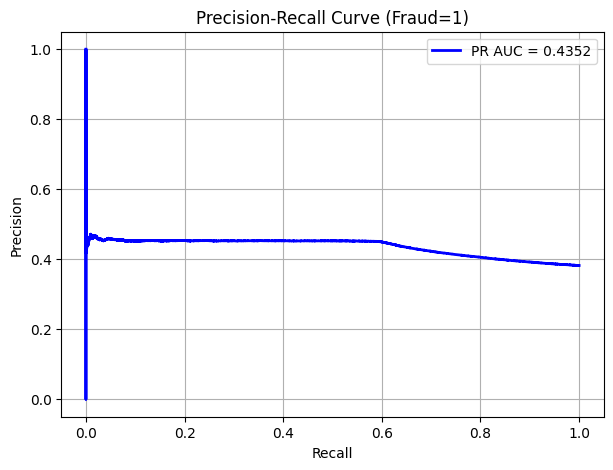


Precision-Recall AUC = 0.4352


In [16]:
# ======================================================================
# CELL 7.2: Define Final XGBoost Model
# ======================================================================
model = XGBClassifier(
    **best_xgb_params,  # unpack the best combination found
    eval_metric='logloss',
    use_label_encoder=False,
    early_stopping_rounds=10,   # still keep early stopping if you like
    random_state=42
)

# ======================================================================
# CELL 8: Training (Early Stopping + eval_set)
# ======================================================================
eval_set = [(X_test_scaled, y_test)]

model.fit(
    X_train_res,
    y_train_res,
    eval_set=eval_set,
    verbose=True
)

# ======================================================================
# CELL 9: Evaluate at multiple thresholds
# ======================================================================
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probability of class=1

def evaluate_threshold(thresh):
    y_pred_t = (y_pred_prob >= thresh).astype(int)
    acc = (y_pred_t == y_test).mean()
    print(f"\nThreshold = {thresh:.2f} | Accuracy = {acc:.4f}")
    print(classification_report(y_test, y_pred_t, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_t))

for t in [0.3, 0.5, 0.7]:
    evaluate_threshold(t)

print("\nXGBoost training complete.")
if hasattr(model, 'best_iteration') and model.best_iteration is not None:
    print(f"Best iteration (based on early stopping): {model.best_iteration}")

# ======================================================================
# CELL 9.1: Plot Precision-Recall Curve
# ======================================================================
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='blue', linewidth=2, label=f'PR AUC = {pr_auc:.4f}')
plt.title("Precision-Recall Curve (Fraud=1)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nPrecision-Recall AUC = {pr_auc:.4f}")


In [17]:
# ======================================================================
# CELL 8: Training (Early Stopping + eval_set)
# ======================================================================
# We'll manually handle early stopping in a second step, or pass it here:
eval_set = [(X_test_scaled, y_test)]

model.fit(
    X_train_res,
    y_train_res,
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-logloss:0.69103
[1]	validation_0-logloss:0.68932
[2]	validation_0-logloss:0.68793
[3]	validation_0-logloss:0.68680
[4]	validation_0-logloss:0.68590


/Users/harshil/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:35:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-logloss:0.68517
[6]	validation_0-logloss:0.68459
[7]	validation_0-logloss:0.68410
[8]	validation_0-logloss:0.68372
[9]	validation_0-logloss:0.68341
[10]	validation_0-logloss:0.68314
[11]	validation_0-logloss:0.68293
[12]	validation_0-logloss:0.68276
[13]	validation_0-logloss:0.68264
[14]	validation_0-logloss:0.68255
[15]	validation_0-logloss:0.68245
[16]	validation_0-logloss:0.68237
[17]	validation_0-logloss:0.68232
[18]	validation_0-logloss:0.68228
[19]	validation_0-logloss:0.68224
[20]	validation_0-logloss:0.68222
[21]	validation_0-logloss:0.68220
[22]	validation_0-logloss:0.68218
[23]	validation_0-logloss:0.68218
[24]	validation_0-logloss:0.68218
[25]	validation_0-logloss:0.68218
[26]	validation_0-logloss:0.68217
[27]	validation_0-logloss:0.68217
[28]	validation_0-logloss:0.68217
[29]	validation_0-logloss:0.68218
[30]	validation_0-logloss:0.68218
[31]	validation_0-logloss:0.68219
[32]	validation_0-logloss:0.68218
[33]	validation_0-logloss:0.68218
[34]	validation_0-l

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [18]:
# ======================================================================
# CELL 9: Evaluate at multiple thresholds
# ======================================================================
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

def evaluate_threshold(thresh):
    y_pred_t = (y_pred_prob >= thresh).astype(int)
    acc = (y_pred_t == y_test).mean()
    ap_score = average_precision_score(y_test, y_pred_t)  # AP on binary preds
    print(f"\nThreshold = {thresh:.2f} | Accuracy = {acc:.4f} | AP(Precision) = {ap_score:.4f}")
    print(classification_report(y_test, y_pred_t, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_t))

# Test a broader set of thresholds, e.g. 0.3, 0.4, 0.5, 0.6, 0.7
for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    evaluate_threshold(t)

print("\nXGBoost training complete.")
if hasattr(model, 'best_iteration') and model.best_iteration is not None:
    print(f"Best iteration (based on early stopping): {model.best_iteration}")


Threshold = 0.30 | Accuracy = 0.3821 | AP(Precision) = 0.3821
              precision    recall  f1-score   support

           0     0.7500    0.0001    0.0002    185371
           1     0.3821    1.0000    0.5529    114629

    accuracy                         0.3821    300000
   macro avg     0.5661    0.5000    0.2765    300000
weighted avg     0.6094    0.3821    0.2114    300000

Confusion Matrix:
 [[    15 185356]
 [     5 114624]]

Threshold = 0.40 | Accuracy = 0.3867 | AP(Precision) = 0.3829
              precision    recall  f1-score   support

           0     0.6833    0.0139    0.0272    185371
           1     0.3829    0.9896    0.5522    114629

    accuracy                         0.3867    300000
   macro avg     0.5331    0.5017    0.2897    300000
weighted avg     0.5685    0.3867    0.2278    300000

Confusion Matrix:
 [[  2570 182801]
 [  1191 113438]]

Threshold = 0.50 | Accuracy = 0.5686 | AP(Precision) = 0.4228
              precision    recall  f1-score   sup


Overall Precision-Recall AUC on probabilities = 0.4352


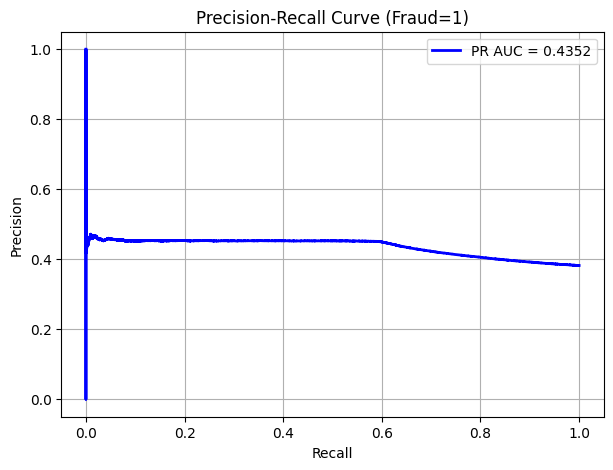

In [19]:
# ======================================================================
# CELL 9.1: Plot or Print Precision-Recall Metrics
# ======================================================================
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"\nOverall Precision-Recall AUC on probabilities = {pr_auc:.4f}")

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='blue', linewidth=2, label=f'PR AUC = {pr_auc:.4f}')
plt.title("Precision-Recall Curve (Fraud=1)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()
